<img src="../logo_skmob.png" width=250 align="left"/>

# Flow models

Generative models of collective spatial flows

In [1]:
import skmob
from skmob.utils import utils, constants
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import matplotlib.pyplot as plt

### Load tessellation and flow data

 - data on county-to-county commute flows in the state of New York. 

 - data from the US Census available at <https://www.census.gov/topics/employment/commuting/data/tables.html> and <https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2011.html>.

In [2]:
tessellation = gpd.GeoDataFrame.from_file("data/NY_counties_2011.geojson")

fdf = skmob.FlowDataFrame.from_file("data/NY_commuting_flows_2011.csv",
                                    tessellation=tessellation, 
                                    tile_id='tile_id', sep=",")
fdf[:4]

,flow,origin,destination
0,121606,36001,36001
1,5,36001,36005
2,29,36001,36007
3,11,36001,36017


Plot the commute flows higher than 1000

In [3]:
fdf.plot_flows(min_flow=1000, tiles='cartodbpositron')#.save('/Users/fs13378/Desktop/m.html')

Compute the total number of commuters from each origin location.

In [4]:
# total outflows excluding self loops
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)['flow'].sum().fillna(0).values
tessellation[constants.TOT_OUTFLOW] = tot_outflows
tessellation[:4]

,tile_id,population,geometry,tot_outflow
0,36019,81716,"POLYGON ((-74.006668 44.886017, -74.027389 44....",29981
1,36101,99145,"POLYGON ((-77.099754 42.274215, -77.0996569999...",5319
2,36107,50872,"POLYGON ((-76.25014899999999 42.296676, -76.24...",295916
3,36059,1346176,"POLYGON ((-73.707662 40.727831, -73.700272 40....",8665


# Gravity

In [5]:
from skmob.models import Gravity

### Instantiate a singly-constrained Gravity model

In [6]:
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


### Generate flows

In [7]:
np.random.seed(0)
scGM_fdf = gravity_singly.generate(tessellation, 
                                       tile_id_column='tile_id', 
                                       tot_outflows_column='tot_outflow', 
                                       relevance_column= 'population',
                                       out_format='flows')
scGM_fdf[:4]

100%|██████████| 62/62 [00:00<00:00, 104.59it/s]
/data2/scikit-mobility/skmob/models/gravity.py:44: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


,origin,destination,flow
0,36019,36101,112
1,36019,36107,55
2,36019,36059,1134
3,36019,36011,140


Plot the generated flows

In [8]:
scGM_fdf.plot_flows(min_flow=1000, tiles='cartodbpositron')#.save('/Users/fs13378/Desktop/m.html')

#### Compare real flows against flows generated by the model

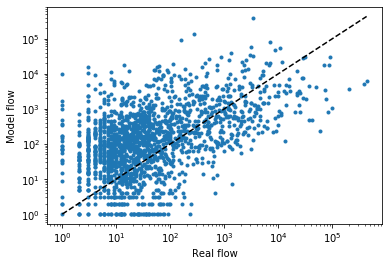

In [9]:
xy = fdf.merge(scGM_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
plt.plot(xy[:,0], xy[:,1], '.')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')
plt.xlabel('Real flow')
plt.ylabel('Model flow')
plt.loglog()
plt.show()

### Fit the gravity model's parameters

In [10]:
gravity_singly_fitted = Gravity(gravity_type='singly constrained')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [11]:
gravity_singly_fitted.fit(fdf, relevance_column='population')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-1.7636438913686285], origin_exp=1.0, destination_exp=0.5906256813012957, gravity_type="singly constrained")


#### Generate flows using the fitted model

In [12]:
np.random.seed(0)
scGM_fdf_fitted = gravity_singly_fitted.generate(tessellation, 
                                   tile_id_column='tile_id', 
                                   tot_outflows_column='tot_outflow', 
                                   relevance_column= 'population',
                                   out_format='flows')
scGM_fdf_fitted[:4]

100%|██████████| 62/62 [00:00<00:00, 140.28it/s]


,origin,destination,flow
0,36019,36101,124
1,36019,36107,71
2,36019,36059,1288
3,36019,36011,147


In [13]:
scGM_fdf_fitted.plot_flows(min_flow=1000, tiles='cartodbpositron')

# Radiation

In [14]:
from skmob.models import Radiation

In [36]:
radiation = Radiation()

In [37]:
np.random.seed(0)
# flows_avg = radiation.generate(st, out_format='flows_average')
rad_flows = radiation.generate(tessellation,  
                               tile_id_column='tile_id', 
                               tot_outflows_column='tot_outflow', 
                               relevance_column='population', out_format='flows_sample')
rad_flows[:4]

100%|██████████| 62/62 [00:00<00:00, 75.81it/s]


,origin,destination,flow
0,36019,36031,9773
1,36019,36033,6111
2,36019,36041,386
3,36019,36113,3708


In [38]:
rad_flows.plot_flows(min_flow=1000, tiles='cartodbpositron')

In [39]:
xy_rad = fdf.merge(rad_flows, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
xy_fitted = fdf.merge(scGM_fdf_fitted, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

#### Compare real flows against flows generated by the models

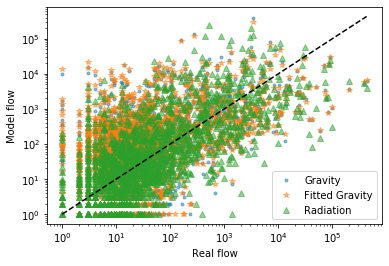

In [43]:
plt.plot(xy[:,0], xy[:,1], '.', alpha=0.5, label='Gravity')
plt.plot(xy_fitted[:,0], xy_fitted[:,1], '*', alpha=0.5, label='Fitted Gravity')
plt.plot(xy_rad[:,0], xy_rad[:,1], '^', alpha=0.5, label='Radiation')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')
plt.xlabel('Real flow');plt.ylabel('Model flow')
plt.legend(loc='lower right');plt.loglog();plt.show()